## Task 1 Part d)

Request URL: https://api.openweathermap.org/data/2.5/weather
Request params: q=Mumbai,IN&appid=***&units=metric
Response status: 200
Response text: {"coord":{"lon":72.8479,"lat":19.0144},"weather":[{"id":800,"main":"Clear","description":"clear sky","icon":"01d"}],"base":"stations","main":{"temp":29.81,"feels_like":29.36,"temp_min":29.81,"temp_max...
Request URL: https://api.openweathermap.org/data/2.5/weather
Request params: q=Delhi,IN&appid=***&units=metric
Response status: 200
Response text: {"coord":{"lon":77.2167,"lat":28.6667},"weather":[{"id":800,"main":"Clear","description":"clear sky","icon":"01d"}],"base":"stations","main":{"temp":31.32,"feels_like":29.2,"temp_min":31.32,"temp_max"...
Request URL: https://api.openweathermap.org/data/2.5/weather
Request params: q=Bangalore,IN&appid=***&units=metric
Response status: 200
Response text: {"coord":{"lon":77.6033,"lat":12.9762},"weather":[{"id":804,"main":"Clouds","description":"overcast clouds","icon":"04d"}],"base":"stations","main

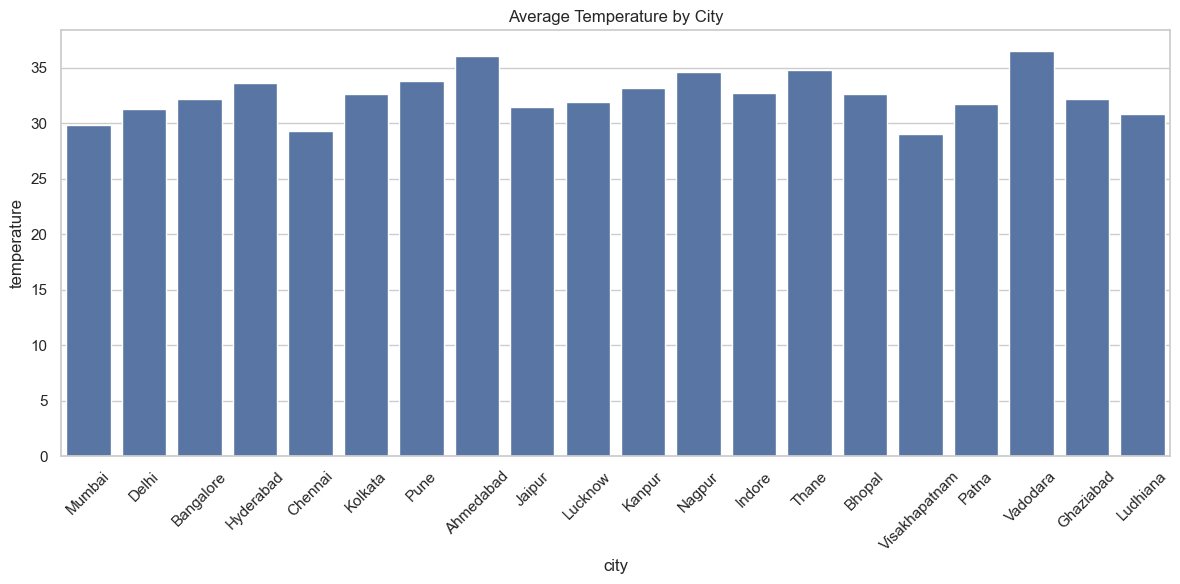

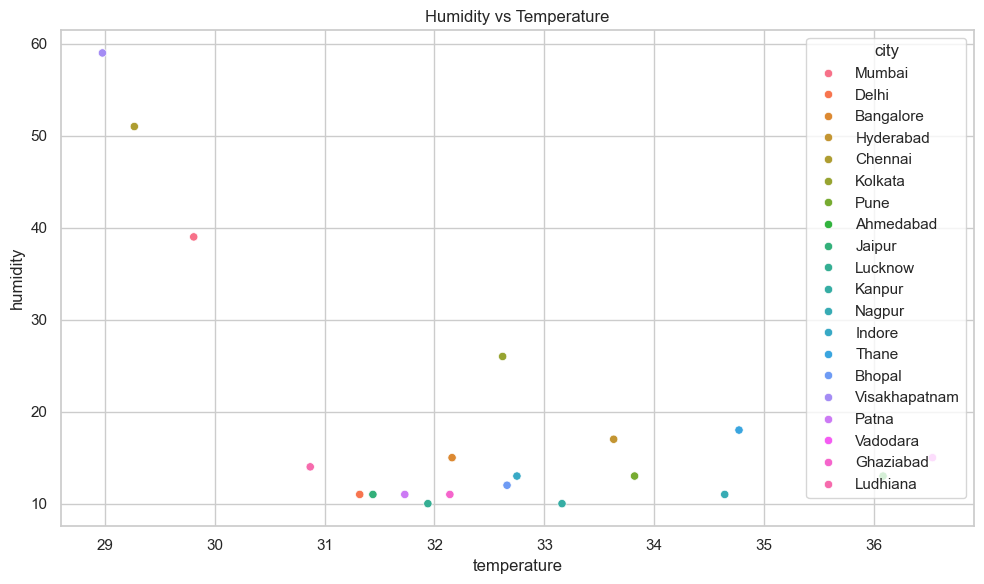

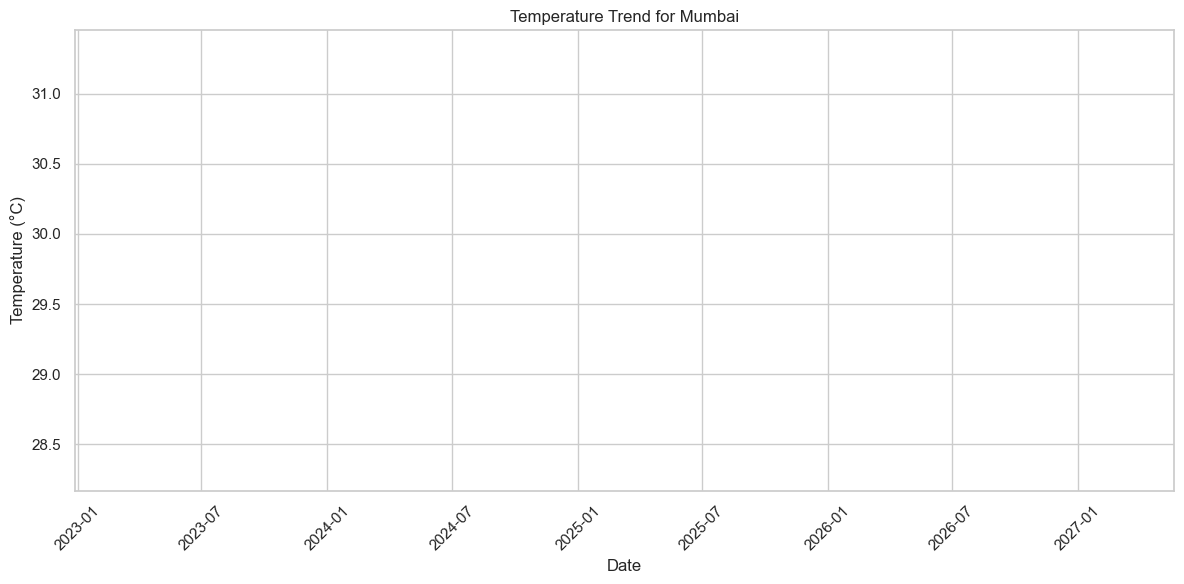

In [1]:
import requests
import pandas as pd
import time
from datetime import datetime, timedelta
import os
import matplotlib.pyplot as plt
import seaborn as sns

class IndiaClimateWatch:
    """
    A class to collect, store, and analyze weather data for Indian cities.
    Dataset Name: IndiaClimateWatch
    """
    
    def __init__(self, api_key):
        """Initialize with OpenWeatherMap API key"""
        self.api_key = api_key
        self.base_url = "https://api.openweathermap.org/data/2.5/weather"
        self.cities = [
            "Mumbai", "Delhi", "Bangalore", "Hyderabad", "Chennai",
            "Kolkata", "Pune", "Ahmedabad", "Jaipur", "Lucknow",
            "Kanpur", "Nagpur", "Indore", "Thane", "Bhopal",
            "Visakhapatnam", "Patna", "Vadodara", "Ghaziabad", "Ludhiana"
        ]
        self.data_dir = "india_climate_data"
        self.ensure_data_directory()
        
    def ensure_data_directory(self):
        """Create data directory if it doesn't exist"""
        if not os.path.exists(self.data_dir):
            os.makedirs(self.data_dir)
            
    def get_weather_data(self, city):
        """Fetch current weather data for a specific city"""
        params = {
            "q": f"{city},IN",
            "appid": self.api_key,
            "units": "metric"  # for Celsius
        }
        
        # Print the URL and params for debugging
        print(f"Request URL: {self.base_url}")
        print(f"Request params: q={city},IN&appid=***&units=metric")
        
        response = requests.get(self.base_url, params=params)
        
        # Print full response for debugging
        print(f"Response status: {response.status_code}")
        print(f"Response text: {response.text[:200]}...")  # Print first 200 chars
        
        if response.status_code == 200:
            data = response.json()
            weather_data = {
                "city": city,
                "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
                "temperature": data["main"]["temp"],
                "feels_like": data["main"]["feels_like"],
                "humidity": data["main"]["humidity"],
                "pressure": data["main"]["pressure"],
                "wind_speed": data["wind"]["speed"],
                "weather_condition": data["weather"][0]["main"],
                "weather_description": data["weather"][0]["description"],
                "clouds": data["clouds"]["all"]
            }
            return weather_data
        else:
            print(f"Error fetching data for {city}: {response.status_code}")
            return None
    
    def collect_all_cities(self):
        """Collect weather data for all cities"""
        all_data = []
        
        for city in self.cities:
            print(f"Collecting data for {city}...")
            city_data = self.get_weather_data(city)
            if city_data:
                all_data.append(city_data)
            # Be nice to the API - avoid rate limiting
            time.sleep(1)
            
        return all_data
    
    def save_to_csv(self, data, filename=None):
        """Save collected data to CSV file"""
        if not data:
            print("No data to save.")
            return
        
        df = pd.DataFrame(data)
        
        if filename is None:
            # Generate filename with current timestamp
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            filename = f"{self.data_dir}/india_weather_{timestamp}.csv"
        else:
            filename = f"{self.data_dir}/{filename}"
            
        df.to_csv(filename, index=False)
        print(f"Data saved to {filename}")
        return filename
    
    def load_csv(self, filename):
        """Load data from a CSV file"""
        full_path = f"{self.data_dir}/{filename}"
        if os.path.exists(full_path):
            return pd.read_csv(full_path)
        else:
            print(f"File not found: {full_path}")
            return None
    
    def collect_periodic_data(self, interval_hours=6, duration_days=30):
        """
        Schedule periodic data collection
        Note: This is a simplified version. In production, you'd use a scheduler like cron.
        """
        total_iterations = (duration_days * 24) // interval_hours
        iteration = 0
        
        print(f"Starting periodic data collection every {interval_hours} hours for {duration_days} days")
        
        while iteration < total_iterations:
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            print(f"\nCollection #{iteration+1} at {timestamp}")
            
            data = self.collect_all_cities()
            self.save_to_csv(data, f"india_weather_{timestamp}.csv")
            
            iteration += 1
            
            if iteration < total_iterations:
                # Calculate next collection time
                next_time = datetime.now() + timedelta(hours=interval_hours)
                print(f"Next collection at {next_time.strftime('%Y-%m-%d %H:%M:%S')}")
                
                # In a real implementation, you'd use a proper scheduler
                # This is just for demonstration
                time.sleep(interval_hours * 3600)  # Convert hours to seconds
    
    def analyze_trends(self, csv_files=None):
        """Analyze weather trends from collected data"""
        if csv_files is None:
            # Use all CSV files in the data directory
            csv_files = [f for f in os.listdir(self.data_dir) if f.endswith('.csv')]
        
        if not csv_files:
            print("No data files found for analysis.")
            return
        
        # Merge all data
        all_data = pd.DataFrame()
        for file in csv_files:
            df = self.load_csv(file)
            if df is not None:
                all_data = pd.concat([all_data, df])
        
        if all_data.empty:
            print("No data loaded for analysis.")
            return
        
        # Convert timestamp to datetime
        all_data['timestamp'] = pd.to_datetime(all_data['timestamp'])
        
        # Sort by timestamp
        all_data = all_data.sort_values('timestamp')
        
        # Basic statistics
        print("\nBasic Statistics:")
        print(all_data[['temperature', 'humidity', 'wind_speed']].describe())
        
        # City comparisons
        city_avg = all_data.groupby('city')[['temperature', 'humidity', 'wind_speed']].mean()
        print("\nCity Averages:")
        print(city_avg)
        
        # Generate visualizations
        self.visualize_data(all_data)
        
        return all_data
    
    def visualize_data(self, df):
        """Create visualizations from the weather data"""
        # Set style
        sns.set(style="whitegrid")
        
        # 1. Temperature comparison across cities
        plt.figure(figsize=(12, 6))
        sns.barplot(x='city', y='temperature', data=df)
        plt.title('Average Temperature by City')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(f"{self.data_dir}/temperature_comparison.png")
        
        # 2. Humidity vs Temperature
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x='temperature', y='humidity', hue='city', data=df)
        plt.title('Humidity vs Temperature')
        plt.tight_layout()
        plt.savefig(f"{self.data_dir}/humidity_vs_temperature.png")
        
        # 3. Time series for a specific city (e.g., Mumbai)
        if 'Mumbai' in df['city'].values:
            mumbai_data = df[df['city'] == 'Mumbai'].sort_values('timestamp')
            
            plt.figure(figsize=(12, 6))
            plt.plot(mumbai_data['timestamp'], mumbai_data['temperature'])
            plt.title('Temperature Trend for Mumbai')
            plt.xlabel('Date')
            plt.ylabel('Temperature (°C)')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.savefig(f"{self.data_dir}/mumbai_temperature_trend.png")
        
        print("Visualizations saved to data directory.")

# Example usage:
if __name__ == "__main__":
    # Replace with your actual OpenWeatherMap API key
    API_KEY = "56a184a8937d739efc17c6a1eb5b1d49"
    
    # Initialize the weather data collector
    india_climate = IndiaClimateWatch(API_KEY)
    
    # For a one-time collection of all cities
    print("Collecting current weather data for all cities...")
    data = india_climate.collect_all_cities()
    csv_file = india_climate.save_to_csv(data)
    
    # Uncomment to run periodic collection (this will run for the specified duration)
    # print("\nStarting periodic collection...")
    # india_climate.collect_periodic_data(interval_hours=6, duration_days=30)
    
    # Analyze the collected data
    print("\nAnalyzing weather data...")
    india_climate.analyze_trends()
    
    print("\nWeather data collection and analysis complete!")

### Collection of periodic weather data over a month

In [1]:
import requests
import pandas as pd
import time
from datetime import datetime, timedelta
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
# API configuration
VISUAL_CROSSING_API_KEY = "SSMZSXE5BDTH6MHBG6RC599P2"  # Sign up for free at visualcrossing.com
OPENWEATHER_API_KEY = "56a184a8937d739efc17c6a1eb5b1d49"


In [3]:
# List of 20 Indian cities
INDIAN_CITIES = [
    "Mumbai", "Delhi", "Bangalore", "Hyderabad", "Chennai", 
    "Kolkata", "Ahmedabad", "Pune", "Jaipur", "Lucknow", 
    "Kanpur", "Nagpur", "Indore", "Thane", "Bhopal", 
    "Visakhapatnam", "Patna", "Vadodara", "Ghaziabad", "Ludhiana"
]

In [ ]:
# Function to get historical weather data using Visual Crossing API
def get_historical_weather(city, start_date, end_date):
    """
    Fetch historical weather data for a city using Visual Crossing API
    Free tier allows limited historical data access
    """
    url = f"https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/{city}/{start_date}/{end_date}"
    params = {
        "unitGroup": "metric",
        "key": VISUAL_CROSSING_API_KEY,
        "include": "days",
        "elements": "datetime,tempmax,tempmin,temp,humidity,windspeed,precip,conditions"
    }
    
    try:
        response = requests.get(url, params=params)
        if response.status_code == 200:
            data = response.json()
            daily_data = []
            
            for day in data.get('days', []):
                daily_data.append({
                    'city': city,
                    'date': day.get('datetime'),
                    'temp_max': day.get('tempmax'),
                    'temp_min': day.get('tempmin'),
                    'temp_avg': day.get('temp'),
                    'humidity': day.get('humidity'),
                    'wind_speed': day.get('windspeed'),
                    'precipitation': day.get('precip'),
                    'conditions': day.get('conditions')
                })
            
            return daily_data
        else:
            print(f"Error fetching historical data for {city}: {response.status_code}")
            return []
    except Exception as e:
        print(f"Exception while fetching historical data for {city}: {e}")
        return []

# Function to get real-time weather data using OpenWeatherMap API
def get_realtime_weather(city):
    """
    Fetch real-time weather data for a city using OpenWeatherMap API
    """
    url = f"https://api.openweathermap.org/data/2.5/weather"
    params = {
        "q": f"{city},IN",
        "appid": OPENWEATHER_API_KEY,
        "units": "metric"
    }
    
    try:
        response = requests.get(url, params=params)
        if response.status_code == 200:
            data = response.json()
            
            weather_data = {
                'city': city,
                'date': datetime.now().strftime('%Y-%m-%d'),
                'temp_max': data['main']['temp_max'],
                'temp_min': data['main']['temp_min'],
                'temp_avg': data['main']['temp'],
                'humidity': data['main']['humidity'],
                'wind_speed': data['wind']['speed'],
                'precipitation': data.get('rain', {}).get('1h', 0) if 'rain' in data else 0,
                'conditions': data['weather'][0]['description'],
                'data_source': 'openweathermap_realtime'
            }
            
            return weather_data
        else:
            print(f"Error fetching real-time data for {city}: {response.status_code}")
            return None
    except Exception as e:
        print(f"Exception while fetching real-time data for {city}: {e}")
        return None

# Function to collect and store data
def collect_weather_data(historical_days=30):
    """
    Collect both historical and real-time weather data and store in a CSV file
    """
    all_data = []
    
    # Set date range for historical data
    end_date = datetime.now().strftime('%Y-%m-%d')
    start_date = (datetime.now() - timedelta(days=historical_days)).strftime('%Y-%m-%d')
    
    # Collect data for each city
    for city in INDIAN_CITIES:
        print(f"Collecting data for {city}...")
        
        # Get historical data
        historical_data = get_historical_weather(city, start_date, end_date)
        if historical_data:
            for entry in historical_data:
                entry['data_source'] = 'visualcrossing_historical'
                all_data.append(entry)
        
        # Get real-time data
        realtime_data = get_realtime_weather(city)
        if realtime_data:
            all_data.append(realtime_data)
        
        # Add delay to avoid hitting API rate limits
        time.sleep(1)
    
    # Create DataFrame and save to CSV
    if all_data:
        df = pd.DataFrame(all_data)
        
        # Create datasets directory if it doesn't exist
        os.makedirs('datasets', exist_ok=True)
        
        # Generate filename with timestamp
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        filename = f"datasets/IndiaWeatherTrends_{timestamp}.csv"
        
        # Save data to CSV
        df.to_csv(filename, index=False)
        print(f"Data saved to {filename}")
        
        return df
    else:
        print("No data collected.")
        return None

# Function to implement periodic data collection
def schedule_data_collection(interval_hours=12, total_days=30):
    """
    Schedule periodic data collection over a month
    """
    total_intervals = int((total_days * 24) / interval_hours)
    
    print(f"Starting scheduled data collection every {interval_hours} hours for {total_days} days...")
    print(f"Total scheduled collections: {total_intervals}")
    
    for i in range(total_intervals):
        print(f"\nCollection {i+1} of {total_intervals}")
        collect_weather_data(historical_days=1)  # Collect just the most recent day to avoid duplication
        
        # Skip sleep on the last iteration
        if i < total_intervals - 1:
            next_collection = datetime.now() + timedelta(hours=interval_hours)
            print(f"Next collection scheduled at: {next_collection}")
            time.sleep(interval_hours * 3600)  # Convert hours to seconds

# Function to analyze and visualize the data
def analyze_weather_data(csv_file):
    """
    Analyze and visualize the weather dataset
    """
    # Read the CSV file
    df = pd.read_csv(csv_file)
    
    # Convert date to datetime
    df['date'] = pd.to_datetime(df['date'])
    
    # Basic statistics
    print("\nBasic Statistics:")
    print(df.describe())
    
    # Create visualizations directory
    os.makedirs('visualizations', exist_ok=True)
    
    # Temperature trends across cities
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='city', y='temp_avg', data=df)
    plt.title('Average Temperature Distribution Across Indian Cities')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig('visualizations/city_temperature_distribution.png')
    
    # Temperature vs Humidity correlation
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='temp_avg', y='humidity', hue='city', data=df)
    plt.title('Temperature vs Humidity Relationship')
    plt.tight_layout()
    plt.savefig('visualizations/temperature_humidity_correlation.png')
    
    # Time series analysis for specific cities
    major_cities = ['Mumbai', 'Delhi', 'Bangalore', 'Chennai', 'Kolkata']
    plt.figure(figsize=(14, 8))
    
    for city in major_cities:
        city_data = df[df['city'] == city].sort_values('date')
        plt.plot(city_data['date'], city_data['temp_avg'], label=city)
    
    plt.title('Temperature Trends Over Time for Major Indian Cities')
    plt.xlabel('Date')
    plt.ylabel('Average Temperature (°C)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('visualizations/temperature_trends_time_series.png')
    
    print("\nAnalysis complete. Visualizations saved to 'visualizations' directory.")
    
    return df

# Example of Use Case: Climate Zone Classification
def climate_zone_classification(df):
    """
    Classify cities into climate zones based on temperature and humidity patterns
    This is a simple example of a use case for the dataset
    """
    # Create aggregated data by city
    city_climate = df.groupby('city').agg({
        'temp_avg': 'mean',
        'humidity': 'mean',
        'wind_speed': 'mean',
        'precipitation': 'mean'
    }).reset_index()
    
    # Simple climate classification (for demonstration)
    def classify_climate(row):
        # These are simplified thresholds for demonstration
        if row['temp_avg'] > 28 and row['humidity'] > 70:
            return 'Hot and Humid'
        elif row['temp_avg'] > 28 and row['humidity'] <= 70:
            return 'Hot and Dry'
        elif row['temp_avg'] > 20 and row['temp_avg'] <= 28 and row['humidity'] > 60:
            return 'Moderate and Humid'
        elif row['temp_avg'] > 20 and row['temp_avg'] <= 28 and row['humidity'] <= 60:
            return 'Moderate and Dry'
        else:
            return 'Cool'
    
    city_climate['climate_zone'] = city_climate.apply(classify_climate, axis=1)
    
    # Visualize climate zones
    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        x='temp_avg', 
        y='humidity', 
        hue='climate_zone', 
        size='precipitation',
        sizes=(50, 200),
        data=city_climate
    )
    
    # Add city labels
    for i, row in city_climate.iterrows():
        plt.text(row['temp_avg'], row['humidity'], row['city'])
        
    plt.title('Climate Zone Classification of Indian Cities')
    plt.xlabel('Average Temperature (°C)')
    plt.ylabel('Average Humidity (%)')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('visualizations/climate_zone_classification.png')
    
    return city_climate

# Main execution
if __name__ == "__main__":
    print("IndiaWeatherTrends Dataset Collection Tool")
    print("----------------------------------------")
    
    #choice = input("Choose an option:\n1. Collect data once\n2. Schedule periodic collection\n3. Analyze existing dataset\nEnter choice (1/2/3): ")
    
    df = collect_weather_data()
    if df is not None:
        print("\nSample of collected data:")
        print(df.head())

IndiaWeatherTrends Dataset Collection Tool
----------------------------------------
Data saved to datasets/IndiaWeatherTrends_20250309_130715.csv

Sample of collected data:
     city        date  temp_max  temp_min  temp_avg  humidity  wind_speed  \
0  Mumbai  2025-02-07      32.8      23.8      28.0      54.3        14.9   
1  Mumbai  2025-02-08      32.9      23.7      28.2      53.2        13.6   
2  Mumbai  2025-02-09      32.4      23.0      28.2      49.4        16.0   
3  Mumbai  2025-02-10      32.0      24.4      27.9      44.3        19.4   
4  Mumbai  2025-02-11      30.4      23.0      26.7      48.1        17.1   

   precipitation conditions                data_source  
0            0.0      Clear  visualcrossing_historical  
1            0.0      Clear  visualcrossing_historical  
2            0.0      Clear  visualcrossing_historical  
3            0.0      Clear  visualcrossing_historical  
4            0.0      Clear  visualcrossing_historical  


## Use case 

#### Climate zone classification


Basic Statistics:
                      date    temp_max    temp_min    temp_avg    humidity  \
count                  640  640.000000  640.000000  640.000000  640.000000   
mean   2025-02-22 11:15:00   30.682328   18.080141   24.181078   51.244531   
min    2025-02-07 00:00:00   20.100000    7.400000   13.700000    8.100000   
25%    2025-02-14 18:00:00   28.175000   14.175000   21.200000   41.700000   
50%    2025-02-22 12:00:00   31.100000   17.700000   24.600000   50.700000   
75%    2025-03-02 06:00:00   33.300000   21.925000   27.000000   63.100000   
max    2025-03-09 00:00:00   38.900000   37.640000   37.640000   91.900000   
std                    NaN    3.439950    5.144608    4.010294   16.084946   

       wind_speed  precipitation  
count  640.000000     640.000000  
mean    16.229922       0.202273  
min      0.320000       0.000000  
25%     13.000000       0.000000  
50%     16.150000       0.000000  
75%     18.725000       0.000000  
max    174.200000      40.008000 

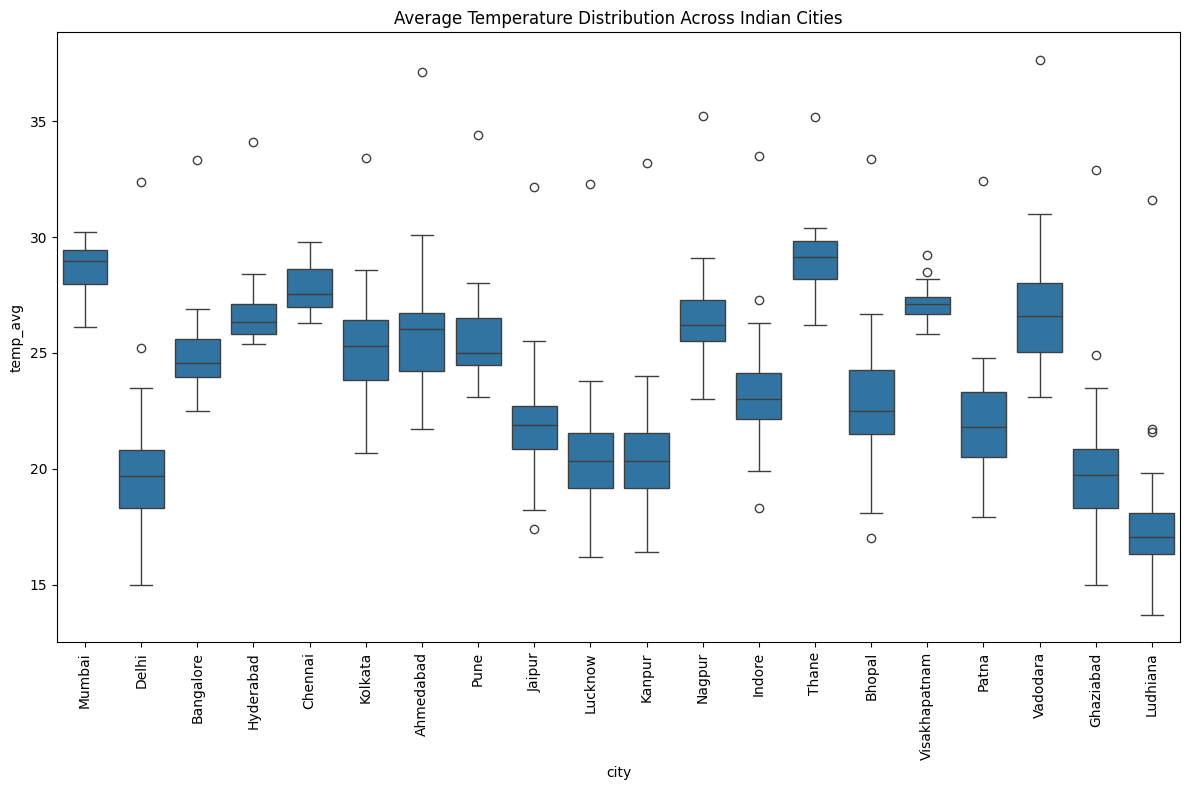

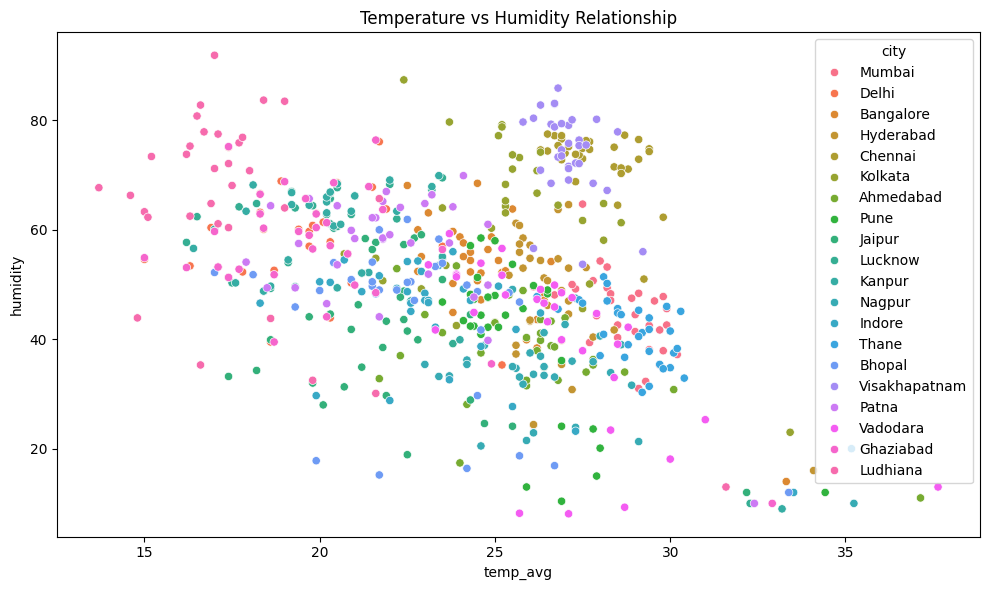

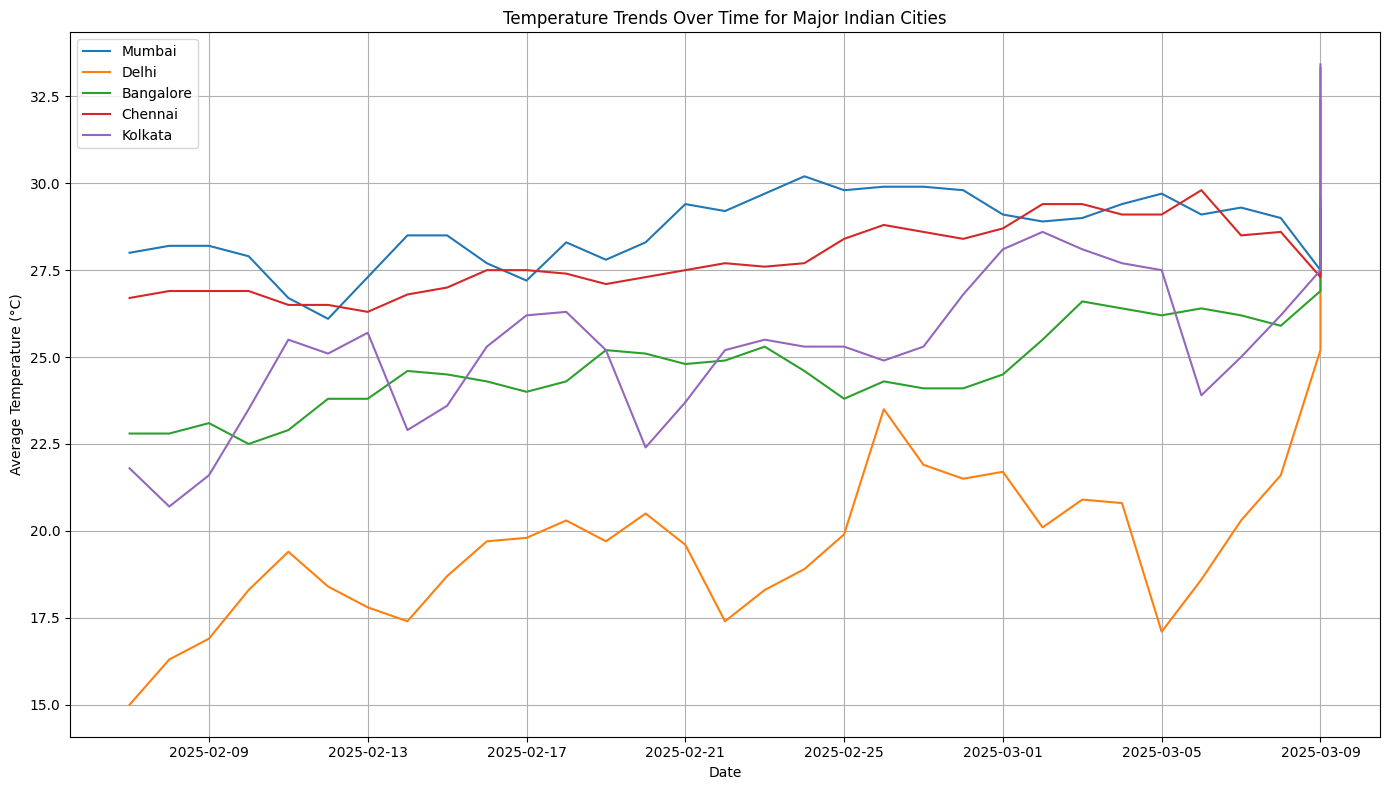

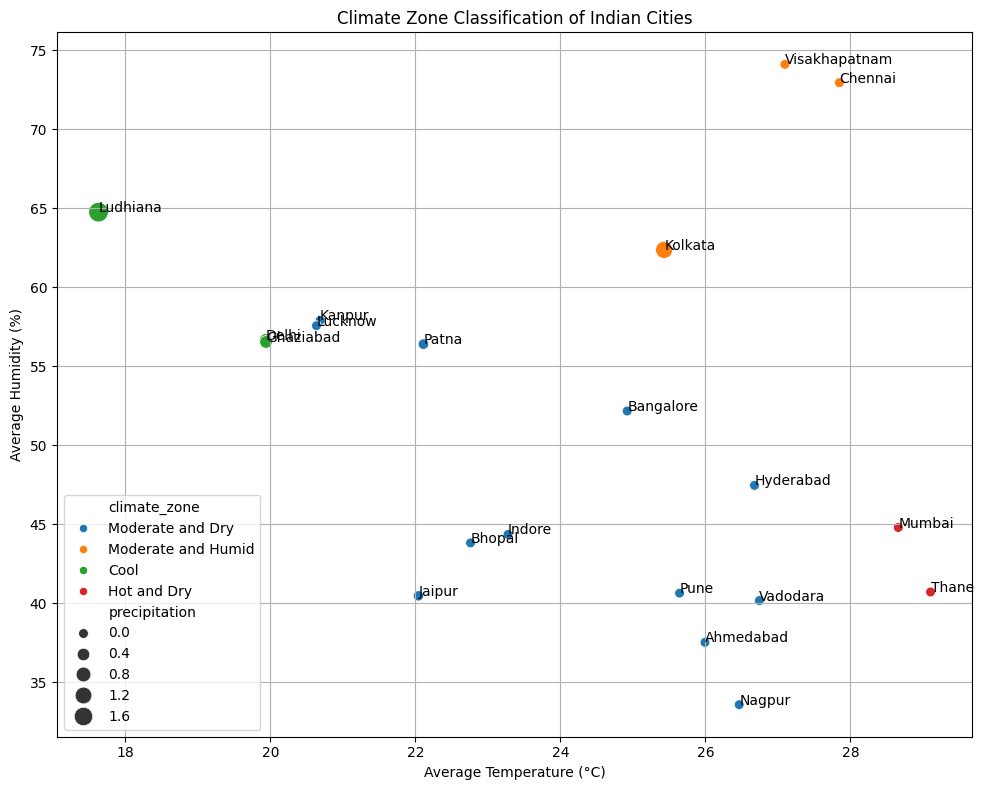

In [11]:
file_path = r"C:\Users\Rishita\Desktop\MMDP-Assignment\Task1_d\india_climate_data\IndiaWeatherTrends_20250309_130715.csv"
if os.path.exists(file_path):
    df = analyze_weather_data(file_path)
    climate_df = climate_zone_classification(df)
    print("\nClimate zone classification:")
    print(climate_df[['city', 'climate_zone']])
    climate_df.to_csv(r'C:\Users\Rishita\Desktop\MMDP-Assignment\Task1_d\Climate Zone Classification\IndiaClimateZones.csv', index=False)

### Scheduled weather data collection


In [ ]:
interval = int(input("Enter collection interval in hours (e.g., 12): "))
days = int(input("Enter total collection period in days (e.g., 30): "))
schedule_data_collection(interval_hours=interval, total_days=days)



Starting scheduled data collection every 5 hours for 5 days...
Total scheduled collections: 24

Collection 1 of 24
Data saved to datasets/IndiaWeatherTrends_20250309_131830.csv
Next collection scheduled at: 2025-03-09 18:18:30.078410


### Agricultural crop Recommendation system


===== Agricultural Crop Recommendation System =====
Analyzing data from: C:\Users\Rishita\Desktop\MMDP-Assignment\Task1_d\india_climate_data\IndiaWeatherTrends_20250309_130715.csv
Loaded data for 20 cities
Optimal number of agricultural clusters: 4

Agricultural Cluster Characteristics:
            temp_avg   humidity  precipitation
Cluster 0  25.663750  42.327557       0.006250
Cluster 1  21.531406  63.564063       1.567047
Cluster 2  27.472969  73.537500       0.000000
Cluster 3  20.662312  57.016875       0.168525

Generating crop recommendations...

Crop planting calendar generated with 0 recommendations

Sample Crop Recommendations (General):
        city recommended_crops
0  Ahmedabad                []
1  Bangalore                []
2     Bhopal                []
3    Chennai                []
4      Delhi                []

Analysis complete. Results saved to 'visualizations' and 'reports' directories.


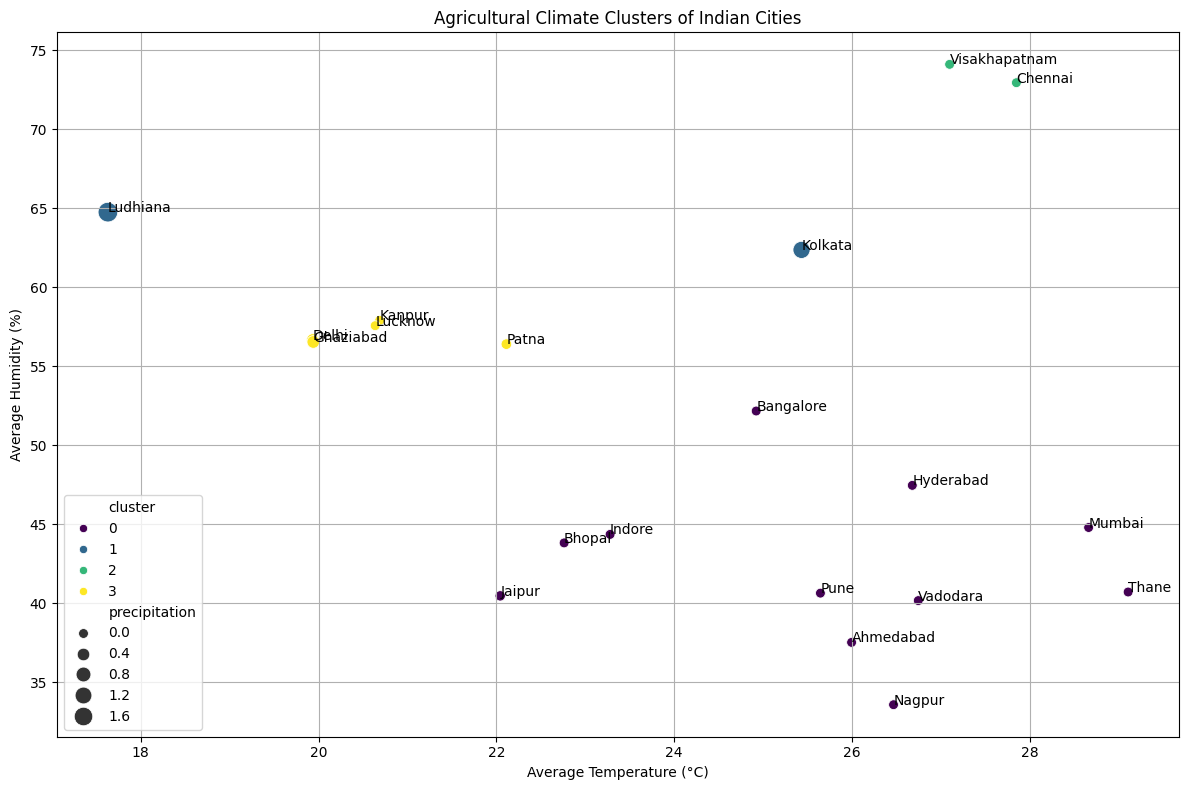

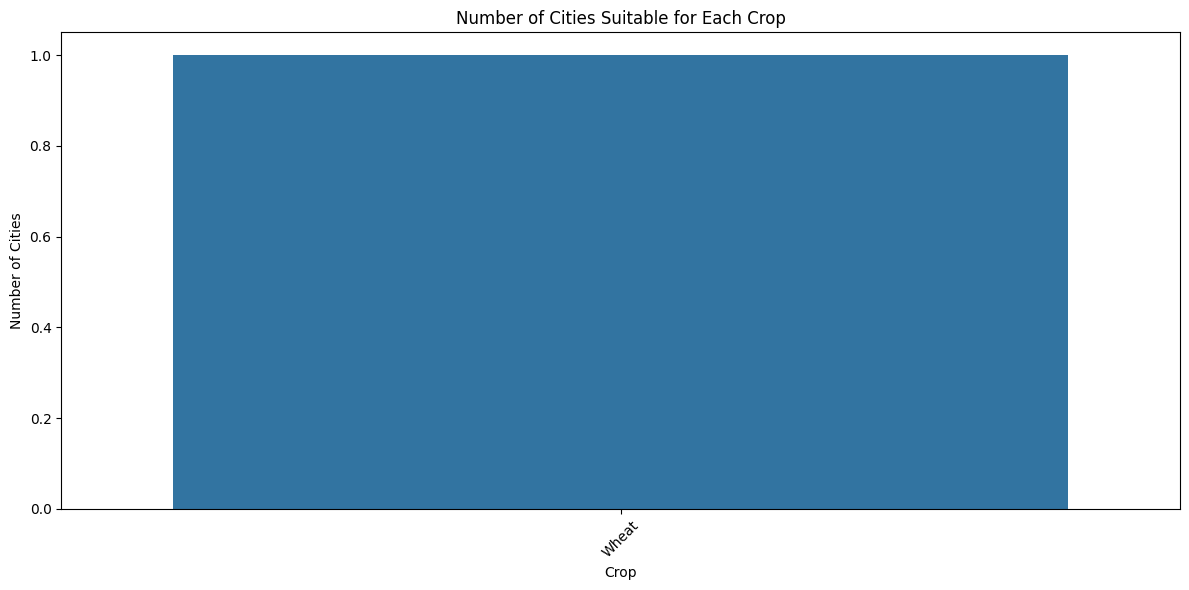

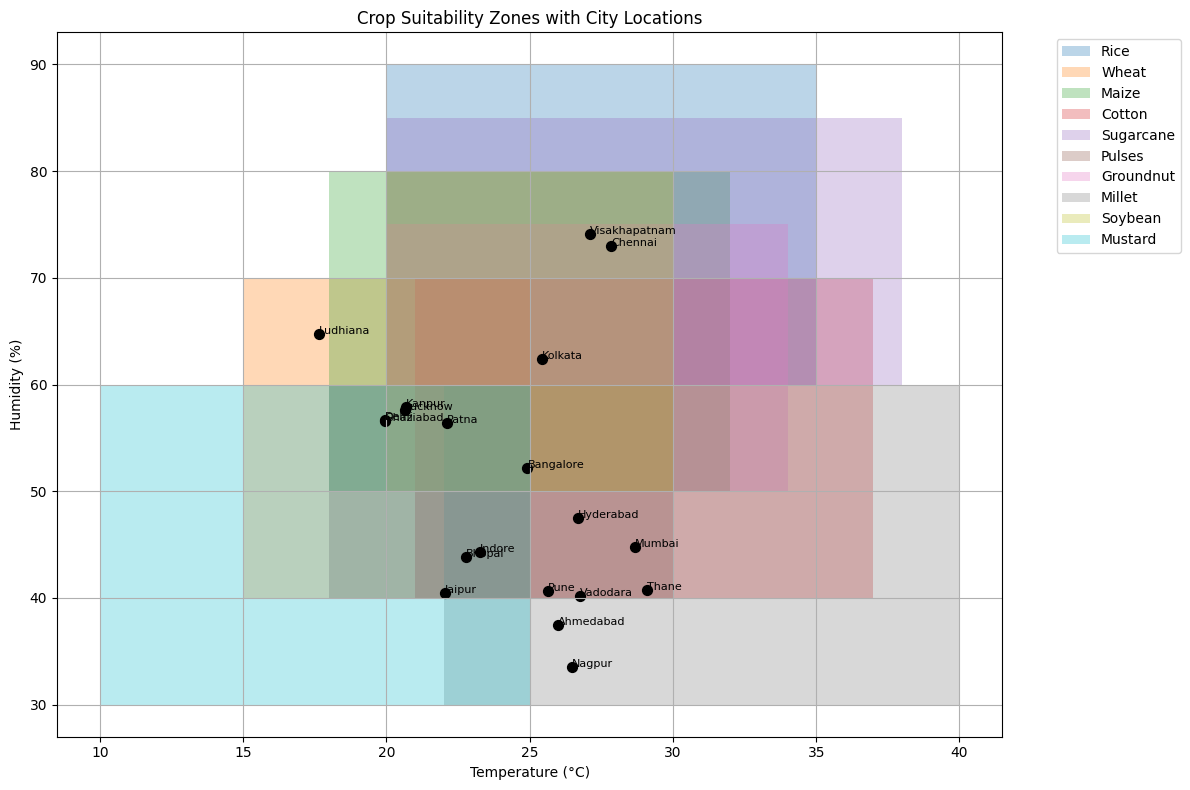

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import os

# Define optimal temperature and humidity ranges for common Indian crops
CROP_REQUIREMENTS = {
    'Rice': {'temp_min': 20, 'temp_max': 35, 'humidity_min': 60, 'humidity_max': 90, 'precipitation_min': 100},
    'Wheat': {'temp_min': 15, 'temp_max': 25, 'humidity_min': 40, 'humidity_max': 70, 'precipitation_min': 50},
    'Maize': {'temp_min': 18, 'temp_max': 32, 'humidity_min': 50, 'humidity_max': 80, 'precipitation_min': 60},
    'Cotton': {'temp_min': 21, 'temp_max': 37, 'humidity_min': 40, 'humidity_max': 70, 'precipitation_min': 80},
    'Sugarcane': {'temp_min': 20, 'temp_max': 38, 'humidity_min': 60, 'humidity_max': 85, 'precipitation_min': 150},
    'Pulses': {'temp_min': 18, 'temp_max': 30, 'humidity_min': 40, 'humidity_max': 60, 'precipitation_min': 40},
    'Groundnut': {'temp_min': 20, 'temp_max': 34, 'humidity_min': 50, 'humidity_max': 75, 'precipitation_min': 70},
    'Millet': {'temp_min': 22, 'temp_max': 40, 'humidity_min': 30, 'humidity_max': 60, 'precipitation_min': 30},
    'Soybean': {'temp_min': 20, 'temp_max': 30, 'humidity_min': 50, 'humidity_max': 80, 'precipitation_min': 60},
    'Mustard': {'temp_min': 10, 'temp_max': 25, 'humidity_min': 30, 'humidity_max': 60, 'precipitation_min': 40}
}

# Season definitions for India
SEASONS = {
    'Winter': [12, 1, 2],
    'Summer': [3, 4, 5, 6],
    'Monsoon': [7, 8, 9],
    'Post-Monsoon': [10, 11]
}

def load_weather_data(csv_file):
    """
    Load and preprocess the weather dataset
    """
    df = pd.read_csv(csv_file)
    
    # Convert date to datetime
    df['date'] = pd.to_datetime(df['date'])
    
    # Add month column for seasonal analysis
    df['month'] = df['date'].dt.month
    
    # Add season column
    def get_season(month):
        for season, months in SEASONS.items():
            if month in months:
                return season
        return 'Unknown'
    
    df['season'] = df['month'].apply(get_season)
    
    return df

def identify_agricultural_clusters(df):
    """
    Use clustering to identify regions with similar agricultural conditions
    """
    # Create aggregated data by city
    city_data = df.groupby('city').agg({
        'temp_avg': 'mean',
        'humidity': 'mean',
        'precipitation': 'mean',
        'wind_speed': 'mean'
    }).reset_index()
    
    # Prepare data for clustering
    features = ['temp_avg', 'humidity', 'precipitation']
    X = city_data[features].values
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Determine optimal number of clusters using silhouette score
    silhouette_scores = []
    K_range = range(2, min(10, len(city_data)))
    
    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        cluster_labels = kmeans.fit_predict(X_scaled)
        silhouette_avg = silhouette_score(X_scaled, cluster_labels)
        silhouette_scores.append(silhouette_avg)
    
    optimal_k = K_range[np.argmax(silhouette_scores)]
    print(f"Optimal number of agricultural clusters: {optimal_k}")
    
    # Apply K-means with optimal k
    kmeans = KMeans(n_clusters=optimal_k, random_state=42)
    city_data['cluster'] = kmeans.fit_predict(X_scaled)
    
    # Get cluster centers
    cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
    cluster_info = pd.DataFrame(
        cluster_centers, 
        columns=features,
        index=[f"Cluster {i}" for i in range(optimal_k)]
    )
    
    print("\nAgricultural Cluster Characteristics:")
    print(cluster_info)
    
    # Visualize clusters
    plt.figure(figsize=(12, 8))
    sns.scatterplot(
        x='temp_avg', 
        y='humidity', 
        hue='cluster', 
        size='precipitation',
        sizes=(50, 200),
        palette='viridis',
        data=city_data
    )
    
    # Add city labels
    for i, row in city_data.iterrows():
        plt.text(row['temp_avg'], row['humidity'], row['city'])
    
    plt.title('Agricultural Climate Clusters of Indian Cities')
    plt.xlabel('Average Temperature (°C)')
    plt.ylabel('Average Humidity (%)')
    plt.grid(True)
    plt.tight_layout()
    
    # Create visualizations directory if it doesn't exist
    os.makedirs('visualizations', exist_ok=True)
    plt.savefig('visualizations/agricultural_clusters.png')
    
    return city_data, cluster_info

def recommend_crops(city_data, df, seasonal=True):
    """
    Recommend suitable crops for each city based on weather data
    """
    recommendations = []
    
    if seasonal:
        # Get seasonal data for more precise recommendations
        seasons = df['season'].unique()
        
        for city in city_data['city']:
            city_recommendations = {'city': city}
            
            for season in seasons:
                season_data = df[(df['city'] == city) & (df['season'] == season)]
                
                if len(season_data) > 0:
                    # Calculate seasonal averages
                    temp_avg = season_data['temp_avg'].mean()
                    humidity_avg = season_data['humidity'].mean()
                    precip_sum = season_data['precipitation'].sum()
                    
                    suitable_crops = []
                    
                    for crop, requirements in CROP_REQUIREMENTS.items():
                        if (requirements['temp_min'] <= temp_avg <= requirements['temp_max'] and
                            requirements['humidity_min'] <= humidity_avg <= requirements['humidity_max'] and
                            precip_sum >= requirements['precipitation_min']):
                            suitable_crops.append(crop)
                    
                    city_recommendations[season] = suitable_crops
            
            recommendations.append(city_recommendations)
    else:
        # Simple non-seasonal recommendations
        for _, row in city_data.iterrows():
            city = row['city']
            temp_avg = row['temp_avg']
            humidity_avg = row['humidity']
            precip_avg = row['precipitation']
            
            suitable_crops = []
            for crop, requirements in CROP_REQUIREMENTS.items():
                if (requirements['temp_min'] <= temp_avg <= requirements['temp_max'] and
                    requirements['humidity_min'] <= humidity_avg <= requirements['humidity_max'] and
                    precip_avg * 30 >= requirements['precipitation_min']):  # Approximate monthly precipitation
                    suitable_crops.append(crop)
            
            recommendations.append({
                'city': city,
                'recommended_crops': suitable_crops
            })
    
    return pd.DataFrame(recommendations)

def visualize_crop_suitability(df, recommendations):
    """
    Create visualizations for crop suitability analysis
    """
    # Create visualizations directory if it doesn't exist
    os.makedirs('visualizations', exist_ok=True)
    
    # Count crop recommendations by city
    if 'recommended_crops' in recommendations.columns:  # Non-seasonal recommendations
        crop_counts = {}
        
        for _, row in recommendations.iterrows():
            city = row['city']
            crops = row['recommended_crops']
            
            for crop in crops:
                if crop not in crop_counts:
                    crop_counts[crop] = 0
                crop_counts[crop] += 1
        
        # Create crop popularity chart
        plt.figure(figsize=(12, 6))
        crop_df = pd.DataFrame({
            'crop': list(crop_counts.keys()),
            'count': list(crop_counts.values())
        }).sort_values('count', ascending=False)
        
        sns.barplot(x='crop', y='count', data=crop_df)
        plt.title('Number of Cities Suitable for Each Crop')
        plt.xlabel('Crop')
        plt.ylabel('Number of Cities')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig('visualizations/crop_popularity.png')
    
    else:  # Seasonal recommendations
        # Create heatmap of seasonal crop diversity
        seasons = [col for col in recommendations.columns if col != 'city']
        
        seasonal_diversity = {}
        for city in recommendations['city']:
            seasonal_diversity[city] = {}
            
            for season in seasons:
                city_season_crops = recommendations[recommendations['city'] == city][season].iloc[0]
                if isinstance(city_season_crops, list):
                    seasonal_diversity[city][season] = len(city_season_crops)
                else:
                    seasonal_diversity[city][season] = 0
        
        diversity_df = pd.DataFrame(seasonal_diversity).T
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(diversity_df, annot=True, cmap='YlGnBu', fmt='d')
        plt.title('Number of Suitable Crops by Season and City')
        plt.tight_layout()
        plt.savefig('visualizations/seasonal_crop_diversity.png')
    
    # Create crop suitability map by temperature and humidity
    plt.figure(figsize=(12, 8))
    
    # Plot temperature and humidity ranges for each crop
    for crop, requirements in CROP_REQUIREMENTS.items():
        plt.fill_between(
            [requirements['temp_min'], requirements['temp_max']],
            [requirements['humidity_min'], requirements['humidity_min']],
            [requirements['humidity_max'], requirements['humidity_max']],
            alpha=0.3,
            label=crop
        )
    
    # Add city points
    city_data = df.groupby('city').agg({
        'temp_avg': 'mean',
        'humidity': 'mean'
    }).reset_index()
    
    plt.scatter(city_data['temp_avg'], city_data['humidity'], c='black', s=50)
    
    for i, row in city_data.iterrows():
        plt.text(row['temp_avg'], row['humidity'], row['city'], fontsize=8)
    
    plt.xlabel('Temperature (°C)')
    plt.ylabel('Humidity (%)')
    plt.title('Crop Suitability Zones with City Locations')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('visualizations/crop_suitability_zones.png')

def generate_crop_calendar(recommendations):
    """
    Generate a planting calendar based on seasonal recommendations
    """
    if 'Winter' not in recommendations.columns:
        print("Seasonal data not available for crop calendar")
        return
    
    # Create a crop calendar showing when to plant each crop for each city
    calendar_data = []
    
    for _, row in recommendations.iterrows():
        city = row['city']
        
        for season in SEASONS.keys():
            if season in row and isinstance(row[season], list):
                for crop in row[season]:
                    calendar_data.append({
                        'city': city,
                        'season': season,
                        'crop': crop,
                        'planting_months': ', '.join([str(m) for m in SEASONS[season]])
                    })
    
    calendar_df = pd.DataFrame(calendar_data)
    
    # Create visualizations directory if it doesn't exist
    os.makedirs('reports', exist_ok=True)
    
    # Save calendar to CSV
    calendar_df.to_csv('reports/crop_planting_calendar.csv', index=False)
    
    print(f"\nCrop planting calendar generated with {len(calendar_df)} recommendations")
    return calendar_df

def run_crop_recommendation_analysis(csv_file):
    """
    Main function to run the crop recommendation analysis
    """
    print("\n===== Agricultural Crop Recommendation System =====")
    print(f"Analyzing data from: {csv_file}")
    
    # Load and preprocess data
    df = load_weather_data(csv_file)
    print(f"Loaded data for {len(df['city'].unique())} cities")
    
    # Identify agricultural clusters
    city_data, cluster_info = identify_agricultural_clusters(df)
    
    # Get crop recommendations
    print("\nGenerating crop recommendations...")
    seasonal_recommendations = recommend_crops(city_data, df, seasonal=True)
    general_recommendations = recommend_crops(city_data, df, seasonal=False)
    
    # Visualize results
    visualize_crop_suitability(df, general_recommendations)
    
    # Generate crop calendar
    calendar = generate_crop_calendar(seasonal_recommendations)
    
    # Print sample recommendations
    print("\nSample Crop Recommendations (General):")
    print(general_recommendations.head())
    
    print("\nAnalysis complete. Results saved to 'visualizations' and 'reports' directories.")
    
    return {
        'city_data': city_data,
        'cluster_info': cluster_info,
        'seasonal_recommendations': seasonal_recommendations,
        'general_recommendations': general_recommendations,
        'calendar': calendar
    }

# Example usage
if __name__ == "__main__":
    file_path = r"C:\Users\Rishita\Desktop\MMDP-Assignment\Task1_d\india_climate_data\IndiaWeatherTrends_20250309_130715.csv"
    if os.path.exists(file_path):
        results = run_crop_recommendation_analysis(file_path)
    else:
        print("File not found!")


The Agricultural Crop Recommendation System leverages the rich weather data collected in the IndiaWeatherTrends dataset to provide data-driven crop selection guidance for 20 Indian cities. This system helps farmers, agricultural planners, and policy makers optimize agricultural practices by matching crop requirements with local climate conditions.

## Problem Statement

India's agricultural sector faces several challenges:

1. **Climate Variability**: Different regions experience vastly different weather patterns
2. **Crop Selection Uncertainty**: Farmers often rely on tradition rather than data for crop selection
3. **Resource Inefficiency**: Growing unsuitable crops leads to wasted resources and reduced yields
4. **Climate Change Adaptation**: Changing weather patterns require adaptive agricultural strategies

## Solution

The Agricultural Crop Recommendation System addresses these challenges by:

1. **Analyzing Weather Patterns**: Processing temperature, humidity, and precipitation data
2. **Identifying Agricultural Clusters**: Grouping cities with similar agricultural conditions
3. **Matching Crop Requirements**: Comparing local conditions to optimal growing parameters
4. **Generating Seasonal Recommendations**: Providing crop suggestions for different seasons
5. **Creating Planting Calendars**: Outlining optimal planting times for recommended crops

## Key Features

### 1. Agricultural Climate Clustering

The system uses machine learning (K-means clustering) to identify regions with similar agricultural conditions. This clustering:

- Groups cities with similar temperature, humidity, and precipitation profiles
- Determines the optimal number of clusters using silhouette analysis
- Provides insights into India's agricultural climate zones
- Visualizes these zones for easy interpretation

### 2. Crop-Climate Matching

The system maintains a knowledge base of optimal growing conditions for 10 common Indian crops.

It then compares each city's climate profile against these requirements to generate suitable crop recommendations.

### 3. Seasonal Analysis

India experiences four primary seasons that significantly impact agricultural practices:

- **Winter** (December-February)
- **Summer** (March-June)
- **Monsoon** (July-September)
- **Post-Monsoon** (October-November)

The system generates season-specific recommendations by analyzing weather data for each season separately, allowing for more precise and actionable guidance.

### 4. Crop Calendar Generation

The system produces planting calendars that show:

- Which crops to plant in each city
- When to plant each recommended crop
- How many different crops are suitable for each season
- Seasonal diversity of crop options

## Visualizations

The system generates several visualizations to aid interpretation:

1. **Agricultural Clusters Map**: Shows cities grouped by agricultural climate similarity
2. **Crop Suitability Zones**: Displays the temperature-humidity requirements for each crop with city positions overlaid
3. **Crop Popularity Chart**: Shows how many cities are suitable for each crop type
4. **Seasonal Crop Diversity Heatmap**: Illustrates how many crop options each city has by season

## Benefits and Applications

### 1. For Farmers and Agricultural Businesses
- **Informed Crop Selection**: Data-driven guidance on which crops will thrive
- **Risk Reduction**: Lower likelihood of crop failure due to poor climate matching
- **Resource Optimization**: Better use of water, fertilizer, and pesticides
- **Yield Improvement**: Higher productivity through appropriate crop selection

### 2. For Agricultural Extension Services
- **Targeted Guidance**: Specific recommendations for different regions
- **Climate-Smart Agriculture**: Adaptation strategies for changing weather patterns
- **Resource Planning**: Better allocation of support resources

### 3. For Policy Makers
- **Regional Planning**: Understanding agricultural potential of different regions
- **Food Security**: Optimizing national crop production
- **Resource Allocation**: Directing subsidies and support to appropriate crops by region

## Future Enhancements

1. **Soil Data Integration**: Combine weather data with soil type and quality information
2. **Market Analysis**: Include crop pricing and market demand factors
3. **Machine Learning Improvements**: Use supervised learning with historical yield data
4. **Mobile Application**: Develop a farmer-friendly app for accessing recommendations
5. **Irrigation Scheduling**: Add irrigation advice based on precipitation patterns
6. **Climate Change Projections**: Incorporate future climate scenarios

## Example Output

### Sample Recommendations for Delhi

**General Recommendations:**
- Recommended Crops: Wheat, Maize, Cotton, Pulses, Groundnut, Millet

**Seasonal Recommendations:**
- Winter: Wheat, Mustard
- Summer: Cotton, Maize, Millet, Groundnut
- Monsoon: Rice, Maize, Soybean
- Post-Monsoon: Pulses, Wheat

## Conclusion

The Agricultural Crop Recommendation System demonstrates a valuable practical application of the IndiaWeatherTrends dataset. By transforming weather data into actionable agricultural insights, the system can help improve agricultural productivity, resource efficiency, and resilience to climate variability across India.

This use case illustrates how weather data collection isn't just about tracking climate patterns—it's about generating practical value for key sectors of the economy and helping address critical challenges in food security and agricultural sustainability.